In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
from torchvision.transforms import ToPILImage, RandomErasing, ColorJitter
from torchsummary import summary
from datetime import datetime
from millify import millify
import random

In [ ]:
!unzip deep-learning-spring-2025-project-1.zip

Archive:  deep-learning-spring-2025-project-1.zip
  inflating: cifar-10-python/cifar-10-batches-py/batches.meta  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_1  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_2  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_3  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_4  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_5  
  inflating: cifar-10-python/cifar-10-batches-py/readme.html  
  inflating: cifar-10-python/cifar-10-batches-py/test_batch  
  inflating: cifar_test_nolabel.pkl  


In [2]:
# Path to the directory containing extracted CIFAR-10 batch files
DATA_PATH = './cifar-10-python/cifar-10-batches-py'

In [3]:
from os.path import isfile
for file in os.listdir(DATA_PATH):
    if isfile(os.path.join(DATA_PATH, file)):
        print(file)

data_batch_1
data_batch_2
batches.meta
test_batch
data_batch_3
data_batch_5
data_batch_4
readme.html


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
def load_batch(batch_file):
    with open(batch_file, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
    images = batch[b'data']
    labels = batch[b'labels']
    # Reshape to (N, 3, 32, 32) and scale pixel values to [0,1]
    images = images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    return images, labels

In [6]:
train_images = []
train_labels = []

for i in range(1, 6):
    batch_file = os.path.join(DATA_PATH, f'data_batch_{i}')
    images, labels = load_batch(batch_file)
    train_images.append(images)
    train_labels.extend(labels)

train_images = np.concatenate(train_images)
train_labels = np.array(train_labels)

print(f'Training data shape: {train_images.shape}, Training labels shape: {train_labels.shape}')

Training data shape: (50000, 3, 32, 32), Training labels shape: (50000,)


In [7]:
test_batch_file = os.path.join(DATA_PATH, 'test_batch')
test_images, test_labels = load_batch(test_batch_file)
print(f'Test data shape: {test_images.shape}')

Test data shape: (10000, 3, 32, 32)


In [41]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    # transforms.RandomResizedCrop(32),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.247, 0.243, 0.261]),
    # RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

In [42]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.247, 0.243, 0.261]),
])

In [43]:
class CIFARDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        # images: already scaled numpy arrays of shape (N, 3, 32, 32)
        self.images = torch.tensor(images).float()  # shape: (N,3,32,32)
        self.labels = torch.tensor(labels) if labels is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image (and label if available)
        image = self.images[idx]
        # If a transform is provided, convert to PIL image and apply it.
        if self.transform:
            image = ToPILImage()(image)
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        return image

In [46]:
# Use the entire training dataset for training
train_dataset = CIFARDataset(train_images, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

# Use the test dataset for validation
val_dataset = CIFARDataset(test_images, test_labels, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
test_dataset = CIFARDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [48]:
class ResidualBlockWithDropout(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.2):
        super(ResidualBlockWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_prob)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

In [49]:
class ModifiedResNetWithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.4):
        super(ModifiedResNetWithDropout, self).__init__()
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn        = nn.BatchNorm2d(64)
        self.relu      = nn.ReLU()
        self.layer1    = self._make_layer(64, 64, blocks=4, stride=1, dropout_prob=dropout_prob)
        self.layer2    = self._make_layer(64, 128, blocks=4, stride=2, dropout_prob=dropout_prob)
        self.layer3    = self._make_layer(128, 256, blocks=3, stride=2, dropout_prob=dropout_prob)
        self.avg_pool  = nn.AdaptiveAvgPool2d((1, 1))
        self.fc        = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride, dropout_prob):
        layers = [ResidualBlockWithDropout(in_channels, out_channels, stride, dropout_prob)]
        for _ in range(1, blocks):
            layers.append(ResidualBlockWithDropout(out_channels, out_channels, dropout_prob=dropout_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn(self.init_conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
model = ModifiedResNetWithDropout(num_classes=10, dropout_prob=0.4).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
ResidualBlockWithDropout-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        Dropout2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14           [-

In [51]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")
if total_params > 5e6:
    print("WARNING: Your model exceeds 5 million parameters!")

Total trainable parameters: 4700682


In [56]:
time = datetime.now().strftime("%d%m%Y%H%M")
params = millify(total_params)

In [57]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [58]:
def train_model(model, train_loader, val_loader, test_loader, epochs=100, lr=0.1, checkpoint_path=f'checkpoint-{params}-{time}.pth', resume=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    
    start_epoch = 0
    if resume and os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # continue from next epoch

    train_losses, val_accuracies, test_accuracies = [], [], []
    
    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        val_acc = evaluate(model, val_loader)
        val_accuracies.append(val_acc)

        test_acc = evaluate(model, test_loader)
        test_accuracies.append(test_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f} - Test Acc: {test_acc:.4f}")

        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_loss
        }
        torch.save(checkpoint, checkpoint_path)
    
    return train_losses, val_accuracies, test_accuracies

In [ ]:
train_losses, val_accuracies, test_accuracies = train_model(model, train_loader, val_loader, test_loader, epochs=120, lr=0.1, resume=False)

Epoch 1/120 - Loss: 1.8587 - Val Acc: 0.3765 - Test Acc: 0.3765
Epoch 2/120 - Loss: 1.5479 - Val Acc: 0.4845 - Test Acc: 0.4845
Epoch 3/120 - Loss: 1.3297 - Val Acc: 0.5730 - Test Acc: 0.5730
Epoch 4/120 - Loss: 1.1480 - Val Acc: 0.6482 - Test Acc: 0.6482
Epoch 5/120 - Loss: 1.0386 - Val Acc: 0.6421 - Test Acc: 0.6421
Epoch 6/120 - Loss: 0.9682 - Val Acc: 0.6642 - Test Acc: 0.6642
Epoch 7/120 - Loss: 0.9069 - Val Acc: 0.7211 - Test Acc: 0.7211
Epoch 8/120 - Loss: 0.8583 - Val Acc: 0.7297 - Test Acc: 0.7297
Epoch 9/120 - Loss: 0.7998 - Val Acc: 0.7463 - Test Acc: 0.7463
Epoch 10/120 - Loss: 0.7539 - Val Acc: 0.7745 - Test Acc: 0.7745
Epoch 11/120 - Loss: 0.7201 - Val Acc: 0.7790 - Test Acc: 0.7790
Epoch 12/120 - Loss: 0.6877 - Val Acc: 0.7606 - Test Acc: 0.7606
Epoch 13/120 - Loss: 0.6677 - Val Acc: 0.7783 - Test Acc: 0.7783
Epoch 14/120 - Loss: 0.6534 - Val Acc: 0.8030 - Test Acc: 0.8030
Epoch 15/120 - Loss: 0.6253 - Val Acc: 0.8011 - Test Acc: 0.8011
Epoch 16/120 - Loss: 0.6173 - Val 

In [30]:
save_model_name = f"modified-resnet-cifar10-{params}-{time}.pth"
torch.save(model.state_dict(), save_model_name)

In [31]:
def plot_metrics(train_losses, val_accuracies, test_accuracies):
    epochs = len(train_losses)
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(15, 5))

    # Plot Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", color="green", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, test_accuracies, label="Test Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

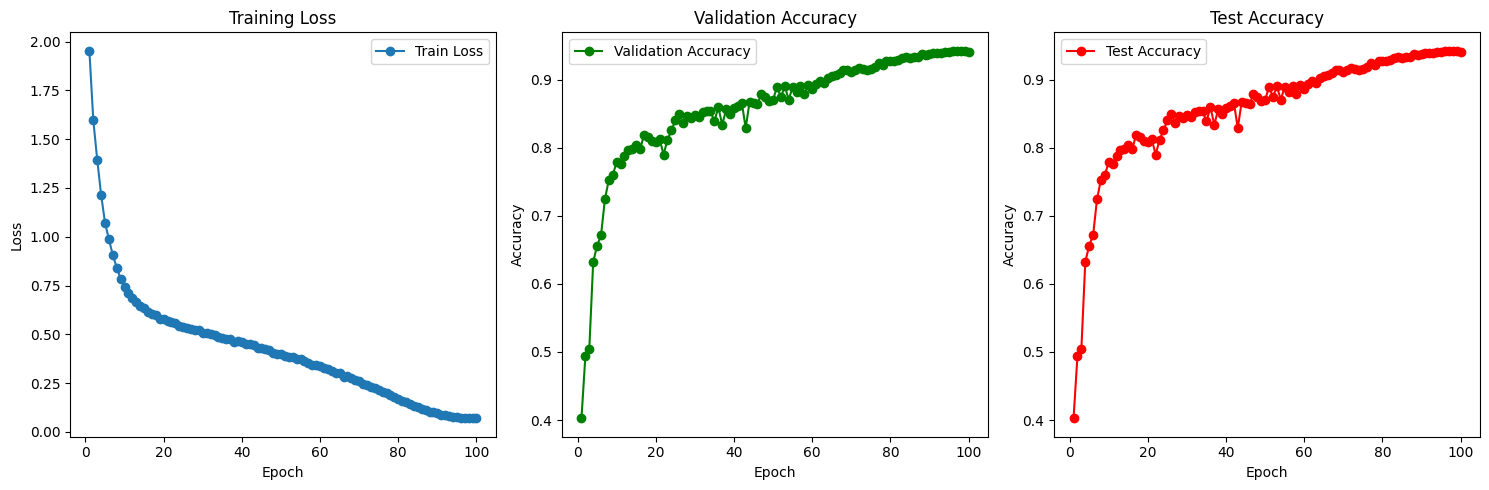

In [32]:
plot_metrics(train_losses, val_accuracies, test_accuracies)

In [33]:
class CIFARTestNoLabelDataset(Dataset):
    def __init__(self, pickle_file, transform=None):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f, encoding='bytes')
        # raw_data is in shape (N, 32, 32, 3)
        raw_data = data[b'data']
        # Transpose to (N, 3, 32, 32) and scale to [0,1]
        self.images = raw_data.transpose(0, 3, 1, 2).astype(np.float32) / 255.0

        # Optionally use provided IDs, otherwise we'll default to indices
        self.ids = data.get(b'ids', None)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]).float()
        if self.transform:
            image = ToPILImage()(image)
            image = self.transform(image)
        # Use the id from the file if available, otherwise use the index.
        if self.ids is not None:
            # Assuming ids are stored as a list of bytes or strings.
            id_val = self.ids[idx]
            # Convert bytes to string if necessary
            if isinstance(id_val, bytes):
                id_val = id_val.decode('utf-8')
        else:
            id_val = idx
        return image, id_val

In [34]:
unlabeled_test_dataset = CIFARTestNoLabelDataset('cifar_test_nolabel.pkl', transform=test_transform)
unlabeled_test_loader = DataLoader(unlabeled_test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [35]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [38]:
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)

def unnormalize(tensor):
    """Unnormalizes a batch of images"""
    return tensor * std.to(tensor.device) + mean.to(tensor.device)

def show_random_predictions(model, test_dataset, class_names, num_images=5):
    model.eval()

    # Randomly select `num_images` images from the dataset
    indices = random.sample(range(len(test_dataset)), num_images)
    images, ids = zip(*[test_dataset[i] for i in indices])  # Extract images and IDs
    
    images_tensor = torch.stack(images).to(device)  # Convert list to tensor and move to GPU
    
    with torch.no_grad():
        outputs = model(images_tensor)
        _, predicted_labels = torch.max(outputs, 1)

    # Unnormalize images for correct visualization
    unnormalized_images = unnormalize(images_tensor).cpu().clamp(0, 1)  # Ensure values are in [0,1]
    
    # Convert images back to NumPy for visualization
    images_np = [transforms.ToPILImage()(img) for img in unnormalized_images]
    
    # Display images with predictions
    fig, axes = plt.subplots(1, num_images, figsize=(8, 5))
    for i in range(num_images):
        axes[i].imshow(images_np[i])
        axes[i].axis("off")
        axes[i].set_title(f"Pred: {class_names[predicted_labels[i].item()]}")

    plt.show()

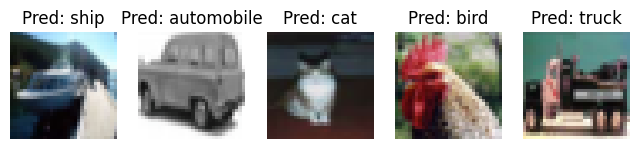

In [39]:
show_random_predictions(model, unlabeled_test_dataset, class_names)

In [36]:
def generate_submission(model, test_loader):
    filename = f"submission-{params}-{time}.csv"
    model.eval()
    ids = []
    preds = []

    with torch.no_grad():
        for images, idxs in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Convert tensors to plain integers
            ids.extend([int(i) for i in idxs])
            preds.extend([int(p) for p in predicted])

    submission_df = pd.DataFrame({"ID": ids, "Labels": preds})
    submission_df.to_csv(filename, index=False)
    print(f"Submission saved to {filename}!")

In [37]:
generate_submission(model, unlabeled_test_loader)

Submission saved to submission-5M-100320251325.csv!
